# Re-grouping streaming text files + Cleaning

## Import 

In [1]:
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Path

In [2]:
stream_path = "tweets/"
stream_files = [os.path.join(stream_path, f) for f in os.listdir(stream_path)]
print stream_files

['tweets/stream_2016_11_09_10-29-31.txt', 'tweets/stream_2016_11_11_10-26-28.txt', 'tweets/stream_2016_11_11_13-45-51.txt', 'tweets/stream_2016_11_11_18-21-15.txt', 'tweets/stream_2016_11_11_19-15-32.txt', 'tweets/stream_2016_11_11_20-54-02.txt', 'tweets/stream_2016_11_11_22-41-26.txt', 'tweets/stream_2016_11_12_13-30-37.txt', 'tweets/stream_2016_11_12_14-35-21.txt', 'tweets/stream_2016_11_13_11-46-26.txt', 'tweets/stream_2016_11_13_12-10-28.txt', 'tweets/stream_2016_11_13_13-49-18.txt', 'tweets/stream_2016_11_13_14-49-18.txt', 'tweets/stream_2016_11_13_15-10-54.txt', 'tweets/stream_2016_11_13_16-10-54.txt', 'tweets/stream_2016_11_13_17-10-54.txt', 'tweets/stream_2016_11_13_18-10-54.txt', 'tweets/stream_2016_11_13_19-10-54.txt', 'tweets/stream_2016_11_13_20-10-54.txt', 'tweets/stream_2016_11_13_21-10-54.txt', 'tweets/stream_2016_11_13_22-10-54.txt', 'tweets/stream_2016_11_13_23-10-54.txt', 'tweets/stream_2016_11_14_00-10-54.txt', 'tweets/stream_2016_11_14_01-10-55.txt', 'tweets/stream_

In [3]:
ACCEPTED_CHARACTERS = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 
                       'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] + \
['%d'%i for i in range(10)] + \
['/', '@', '#', '&', '\x98', '\x92', '\xf0', '\x9f', '\x80', '\xa6', '\xe2'] + \
['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', ':', ';', '?', '_']

ACCEPTED_CHARACTERS.sort()

print len(ACCEPTED_CHARACTERS), "accepted characters"

62 accepted characters


In [4]:
print ACCEPTED_CHARACTERS

['\n', ' ', '!', '"', '#', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x80', '\x92', '\x98', '\x9f', '\xa6', '\xe2', '\xf0']


## Custom functions

In [5]:
def open_and_read(f):
    with open(f, "r") as f:
        lines = f.readlines()
    header = lines[0:3]
    tweets = lines[3:]
    return header, tweets

In [6]:
def extract_next_tweet(indice, tweets):
    tweet = tweets[indice]
    indice += 1
    count = 0
    while tweet.find("<end>") < 0 and count < 100:
        tweet += tweets[indice]
        indice += 1
        count += 1
    return tweet, indice

def tweet_cleaning(tweet, accepted_caracters=[]):
    # Removing the 'start', 'end' markers
    t = tweet.replace("<start>", "")
    t = t.replace("<end>\n", "")
    t = t.replace("text:", "")
    # Lowercase 
    t = t.lower()
    # Reject tweet with non-accepted characters
    if accepted_caracters:
        if set(list(t.lower())).issubset(set(accepted_caracters)): # No need to clean
            return t 
        else:
            for char in t:
                if char not in accepted_caracters:
                    t = t.replace(char, "")
            # Removing multiple spaces
            t = re.sub(' +',' ', t)
    return t

# Test 

### Open a stream file

In [7]:
header, tweets = open_and_read(stream_files[2])
print "HEADER :\n", header
print "TWEETS :\n", tweets[0:4]

HEADER :
['Description: \n', "Queries: ['a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z']\n", "Keys: ['text']\n"]
TWEETS :
['<start>text:Legendary Lovers https://t.co/7TEbeg5Hhx<end>\n', "<start>text:She said I know you don't think of me when you think too much<end>\n", '<start>text:Presidents who behave like actual human beings vs. "Grab them by the pussy"  https://t.co/9feGpKDc3s via @YouTube<end>\n', "<start>text:RT @iSmashFizzle: I'm buying 20 of em https://t.co/dl2Gxo4AnA<end>\n"]


### Extract a tweet at position x

In [8]:
x = 0
tweet, new_x = extract_next_tweet(x, tweets)
print tweet

<start>text:Legendary Lovers https://t.co/7TEbeg5Hhx<end>



### Cleaning a tweet

- Removing smileys
- Removing markers (such as "<start>", "<end>"...)
- Labelize

In [10]:
tweet, new_x = extract_next_tweet(new_x, tweets)
cleaned_tweet = tweet_cleaning(tweet, ACCEPTED_CHARACTERS)
print cleaned_tweet
#print "Label :", label
#print "Smiley :", smiley

presidents who behave like actual human beings vs. "grab them by the pussy"  https://t.co/9fegpkdc3s via @youtube


## Extracting/Cleaning all tweets available

In [12]:
tweets = []

tweet_count = 0
for stream_file in stream_files:
    print "\n", stream_file
    # Open and read file
    header, ts = open_and_read(stream_file)
    # Extracting tweet loop
    counter = 0
    while counter < len(ts)-1:
        # Extract
        t, counter = extract_next_tweet(counter, ts)
        # Clean
        t = tweet_cleaning(t, accepted_caracters=ACCEPTED_CHARACTERS)
        
        # Store
        if t is not None:
            tweets.append(t)
            # Tweet count
            tweet_count += 1
        print "\rTweet count = %d"%tweet_count,


tweets/stream_2016_11_09_10-29-31.txt
Tweet count = 24275 
tweets/stream_2016_11_11_10-26-28.txt
Tweet count = 28515 
tweets/stream_2016_11_11_13-45-51.txt
Tweet count = 201295 
tweets/stream_2016_11_11_18-21-15.txt
Tweet count = 261455 
tweets/stream_2016_11_11_19-15-32.txt
Tweet count = 434159 
tweets/stream_2016_11_11_20-54-02.txt
Tweet count = 601558 
tweets/stream_2016_11_11_22-41-26.txt
Tweet count = 774342 
tweets/stream_2016_11_12_13-30-37.txt
Tweet count = 947125 
tweets/stream_2016_11_12_14-35-21.txt
Tweet count = 949252 
tweets/stream_2016_11_13_11-46-26.txt
Tweet count = 961684 
tweets/stream_2016_11_13_12-10-28.txt
Tweet count = 1134471 
tweets/stream_2016_11_13_13-49-18.txt
Tweet count = 1307272 
tweets/stream_2016_11_13_14-49-18.txt
Tweet count = 1362347 
tweets/stream_2016_11_13_15-10-54.txt
Tweet count = 1535146 
tweets/stream_2016_11_13_16-10-54.txt
Tweet count = 1707915 
tweets/stream_2016_11_13_17-10-54.txt
Tweet count = 1880683 
tweets/stream_2016_11_13_18-10-54.t

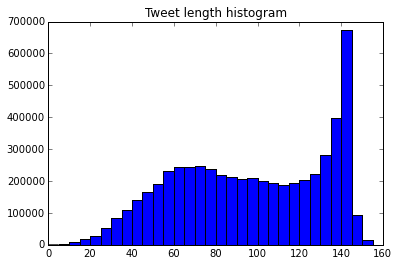

In [13]:
len_tweets = [len(t) for t in tweets]

%matplotlib inline
plt.title("Tweet length histogram")
plt.hist(len_tweets, bins=np.arange(0, 160, 5))
plt.show()

#### Print some long tweets (>140 char)

In [14]:
count = 0
for t in tweets:
    if len(t)>140:
        print "Tweet of length %d :"%len(t), t
        count += 1
    if count > 20:
        break

Tweet of length 142 : rt @mistercapone: i've always thought we were equally divided but i see now i was being naive. i really have no idea how divided we are. or…
Tweet of length 142 : rt @phillyfanlife: the world's ending just as the eagles get a franchise qb and the sixers, flyers and phils have legit cornerstone pieces.…
Tweet of length 141 : what should organisations consider if they are to prepare for cyber insurance?  november 09, 2016 at 05:00pm 
comp… https://t.co/oaaiuzapct
Tweet of length 145 : rt @lhfang: hillary team's strategy of directly &amp; implicitly (#imwithher) accusing *all* critics of sexism fueled bitter resentment on the…
Tweet of length 142 : rt @calaiii_: dear muslims, immigrants, woman, disabled, and all people of color, 
i love you- boldly and proudly. we will endure. 
we will…
Tweet of length 143 : rt @pettyblackgiri: if your political ideals include racism, misogyny, xenophobia, homophobia, transphobia, &amp; excuses for sexual predat… 
Tweet of length 142

# Convert to one-hot

In [21]:
def one_hot_char(char, accepted_characters):
    one_hot = np.zeros(len(accepted_characters)+1)
    for i, accepted_char in zip(range(len(accepted_characters)),accepted_characters):
        if char == accepted_char:
            one_hot[i] = 1
            break
    return one_hot

def one_hot_sentence(sentence, accepted_characters):
    # Char by char one-hot encoding
    one_hot = [one_hot_char(char, accepted_characters) for char in sentence]
    # Add a special char for the 'end' of the sentence : [0,0,....,0,0,1]
    special_char = np.zeros(len(accepted_characters)+1)
    special_char[-1] = 1
    one_hot += [special_char]
    # Return as a numpy array of shape (len(sentence), len(accepted_char))
    return np.array(one_hot, "uint8")

def char2label(char, accepted_characters):
    for i, accepted_char in zip(range(len(accepted_characters)),accepted_characters):
        if char == accepted_char:
            label = i
            break
    return np.array([label])

def sentence2label(sentence, accepted_characters):
    # Char by char one-hot encoding
    one_hot = [char2label(char, accepted_characters) for char in sentence]
    # Add a special char for the 'end' of the sentence : [D]
    special_char = [len(accepted_characters)]
    one_hot += [special_char]
    # Return as a numpy array of shape (len(sentence), len(accepted_char))
    return np.array(one_hot, "uint8")

def length_management(one_hot_sentence, max_len, mode="label", padding=len(ACCEPTED_CHARACTERS)+1):
    '''Padding such that each sentence contains 'max_len' timesteps.'''
    if one_hot_sentence.shape[0]>=max_len: # too long
        return one_hot_sentence[0:max_len]
    else:
        if mode == "one-hot":
            # Padding
            zero_padding = np.zeros((1,one_hot_sentence.shape[1]), "uint8")
            one_hot_sentence = np.vstack((one_hot_sentence, 
                                          zero_padding.repeat(max_len-one_hot_sentence.shape[0], axis=0)))
        else:
            padding = np.ones((max_len-one_hot_sentence.shape[0],1), "uint8")*padding
            one_hot_sentence = np.vstack((one_hot_sentence, padding))
        return one_hot_sentence

### Demo on one tweet

In [22]:
# Pick a tweet
n = np.random.randint(0,len(tweets))
tweet = tweets[n]
print tweet
# One-hot
one_hot_tweet = one_hot_sentence(tweets[0], ACCEPTED_CHARACTERS)
print "\nOne-hot encoding of size :", one_hot_tweet.shape
print one_hot_tweet
# Padding
one_hot_tweet = length_management(one_hot_tweet, 160, mode="one-hot")
print "\nAfter padding :", one_hot_tweet.shape
print one_hot_tweet

rt @kobinaturkson: table reservations for #megajam2016 
@colony_clutch @nkktghana https://t.co/jnezfiwz79

One-hot encoding of size : (87L, 63L)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 1 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]

After padding : (160L, 63L)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


#### But One-Hot encoding : too heavy to store... 

#### Cheaper : just keeping the index where encoding == 1

In [24]:
# Pick a tweet
n = np.random.randint(0,len(tweets))
tweet = tweets[n]
print tweet
# One-hot
one_hot_tweet = sentence2label(tweets[0], ACCEPTED_CHARACTERS)
print "\nChar2Label encoding of size :", one_hot_tweet.shape
print one_hot_tweet[0:5], "\n...\n", one_hot_tweet[-5:]
# Padding
one_hot_tweet = length_management(one_hot_tweet, 160, mode="label")
print "\nAfter padding :", one_hot_tweet.shape
print one_hot_tweet[0:5], "\n...\n", one_hot_tweet[-5:]

rt @johnnynami: when yo girl on her period but she crip https://t.co/bw61gj5h9e

Char2Label encoding of size : (87L, 1L)
[[53]
 [29]
 [40]
 [40]
 [ 1]] 
...
[[ 1]
 [ 2]
 [ 2]
 [ 2]
 [62]]

After padding : (160L, 1L)
[[53]
 [29]
 [40]
 [40]
 [ 1]] 
...
[[63]
 [63]
 [63]
 [63]
 [63]]


## Encoding the whole dataset

In [29]:
T = 160
D = 1 # len(ACCEPTED_CARACTERS)+1 if one-hot
# Instanciate
dataset = np.zeros((len(tweets), T, D), "uint8")
# Fill in
for k,t in enumerate(tweets):
    # One-hot encoding
    one_hot_tweet = sentence2label(t, ACCEPTED_CHARACTERS)
    # Padding
    dataset[k] = length_management(one_hot_tweet, T)
    # Print 
    print "\rCount = %d"%k,
print " tweets."

Count = 5520597  tweets.


# Save

In [30]:
np.save("data/dataset.npy", dataset)